In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
import acd
from copy import deepcopy
from model_fashion_mnist import Net, Net2c, FashionCNN
import dset_fashion_mnist as dset
from visualize import *
import foolbox
sys.path.append('../trim')
from transforms_torch import transform_bandpass, tensor_t_augment, batch_fftshift2d, batch_ifftshift2d
from trim import *
from util import *
from attributions import *
from captum.attr import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
# set args
args = dset.get_args()
args.cuda = "True"
args.test_batch_size = 100

# load fashion-mnist dataset
train_loader, test_loader = dset.load_data(args.batch_size, args.test_batch_size, device, shuffle_target=False)

# model
model1 = FashionCNN().to(device)
model1.load_state_dict(torch.load('models/FashionCNN_epochs=5.pth', map_location=device))
model1 = model1.eval()
dset.test(train_loader, model1, args)

model2 = FashionCNN().to(device)
model2.load_state_dict(torch.load('models/FashionCNN_epochs=10.pth', map_location=device))
model2 = model2.eval()
dset.test(train_loader, model2, args)

model3 = FashionCNN().to(device)
model3.load_state_dict(torch.load('models/FashionCNN_epochs=50.pth', map_location=device))
model3 = model3.eval()
dset.test(train_loader, model3, args)


Test set: Average loss: 0.2084, Accuracy: 55438/60000 (92.40%)


Test set: Average loss: 0.1405, Accuracy: 56902/60000 (94.84%)


Test set: Average loss: 0.1255, Accuracy: 57763/60000 (96.27%)



In [3]:
# FFT
t = lambda x: torch.fft(torch.stack((x, torch.zeros_like(x)),dim=4), 2)
transform_i = modularize(lambda x: torch.ifft(x, 2)[...,0])
band_center = 0.6
band_width_lower = 0.0
band_width_upper = np.Inf
t_bandpasser = lambda x: transform_bandpass(x, band_center, band_width_lower, band_width_upper)

# prepend transformation
model1_t = TrimModel(model1, transform_i)
model2_t = TrimModel(model2, transform_i)
model3_t = TrimModel(model3, transform_i)

## attributions on the low- and high-frequency


In [4]:
# mask band
img_size = 28
mask = 1 - freq_band(img_size, band_center, band_width_lower, band_width_upper)
scores1 = {
    'IG': [],
    'DeepLift': [],
    'SHAP': [],
    'Saliency': [],
    'InputXGradient': []
}
attr_methods = ['IG', 'DeepLift', 'SHAP', 'Saliency', 'InputXGradient']

In [5]:
for batch_idx, (im, label) in enumerate(test_loader):
    im = im.to(device)
    im_t = t(im)
    label = label.to(device)
    
    # attr
    results = get_attributions(im_t, model1_t, class_num=label,
                               attr_methods = ['IG', 'DeepLift', 'SHAP', 'Saliency', 'InputXGradient']) 
    for i, name in enumerate(attr_methods):
        low_attr = (fftshift(results[name]) * mask).sum(axis=(1,2))
        high_attr = (fftshift(results[name]) * (1-mask)).sum(axis=(1,2))
        scores1[name].append(np.c_[low_attr, high_attr]) 

    print('\riteration:', batch_idx, end='')

scores1['IG'] = np.vstack(scores1['IG'])
scores1['DeepLift'] = np.vstack(scores1['DeepLift'])
scores1['SHAP'] = np.vstack(scores1['SHAP'])
scores1['Saliency'] = np.vstack(scores1['Saliency'])
scores1['InputXGradient'] = np.vstack(scores1['InputXGradient'])     
# pkl.dump(scores, open('scores.pkl', 'wb'))

iteration: 99

In [ ]:
plt.hist(scores['IG'][:,0] - scores['IG'][:,1])
plt.show()

In [ ]:
plt.hist(scores['DeepLift'][:,0] - scores['DeepLift'][:,1])
plt.show()

In [ ]:
plt.hist(scores['SHAP'][:,0] - scores['SHAP'][:,1])
plt.show()

In [ ]:
plt.hist(scores['Saliency'][:,0] - scores['Saliency'][:,1])
plt.show()

In [ ]:
plt.hist(scores['InputXGradient'][:,0] - scores['InputXGradient'][:,1])
plt.show()

## attributions on the low- and high-frequency


In [6]:
# mask band
img_size = 28
mask = 1 - freq_band(img_size, band_center, band_width_lower, band_width_upper)
scores2 = {
    'IG': [],
    'DeepLift': [],
    'SHAP': [],
    'Saliency': [],
    'InputXGradient': []
}
attr_methods = ['IG', 'DeepLift', 'SHAP', 'Saliency', 'InputXGradient']

In [7]:
for batch_idx, (im, label) in enumerate(test_loader):
    im = im.to(device)
    im_t = t(im)
    label = label.to(device)
    
    # attr
    results = get_attributions(im_t, model2_t, class_num=label,
                               attr_methods = ['IG', 'DeepLift', 'SHAP', 'Saliency', 'InputXGradient']) 
    for i, name in enumerate(attr_methods):
        low_attr = (fftshift(results[name]) * mask).sum(axis=(1,2))
        high_attr = (fftshift(results[name]) * (1-mask)).sum(axis=(1,2))
        scores2[name].append(np.c_[low_attr, high_attr]) 

    print('\riteration:', batch_idx, end='')

scores2['IG'] = np.vstack(scores2['IG'])
scores2['DeepLift'] = np.vstack(scores2['DeepLift'])
scores2['SHAP'] = np.vstack(scores2['SHAP'])
scores2['Saliency'] = np.vstack(scores2['Saliency'])
scores2['InputXGradient'] = np.vstack(scores2['InputXGradient'])     
# pkl.dump(scores, open('scores.pkl', 'wb'))

iteration: 99

In [ ]:
plt.hist(scores['IG'][:,0] - scores['IG'][:,1])
plt.show()

In [ ]:
plt.hist(scores['DeepLift'][:,0] - scores['DeepLift'][:,1])
plt.show()

In [ ]:
plt.hist(scores['SHAP'][:,0] - scores['SHAP'][:,1])
plt.show()

In [ ]:
plt.hist(scores['Saliency'][:,0] - scores['Saliency'][:,1])
plt.show()

In [ ]:
plt.hist(scores['InputXGradient'][:,0] - scores['InputXGradient'][:,1])
plt.show()

## attributions on the low- and high-frequency


In [8]:
# mask band
img_size = 28
mask = 1 - freq_band(img_size, band_center, band_width_lower, band_width_upper)
scores3 = {
    'IG': [],
    'DeepLift': [],
    'SHAP': [],
    'Saliency': [],
    'InputXGradient': []
}
attr_methods = ['IG', 'DeepLift', 'SHAP', 'Saliency', 'InputXGradient']

In [9]:
for batch_idx, (im, label) in enumerate(test_loader):
    im = im.to(device)
    im_t = t(im)
    label = label.to(device)
    
    # attr
    results = get_attributions(im_t, model3_t, class_num=label,
                               attr_methods = ['IG', 'DeepLift', 'SHAP', 'Saliency', 'InputXGradient']) 
    for i, name in enumerate(attr_methods):
        low_attr = (fftshift(results[name]) * mask).sum(axis=(1,2))
        high_attr = (fftshift(results[name]) * (1-mask)).sum(axis=(1,2))
        scores3[name].append(np.c_[low_attr, high_attr]) 

    print('\riteration:', batch_idx, end='')

scores3['IG'] = np.vstack(scores3['IG'])
scores3['DeepLift'] = np.vstack(scores3['DeepLift'])
scores3['SHAP'] = np.vstack(scores3['SHAP'])
scores3['Saliency'] = np.vstack(scores3['Saliency'])
scores3['InputXGradient'] = np.vstack(scores3['InputXGradient'])     
# pkl.dump(scores, open('scores.pkl', 'wb'))

iteration: 99

In [ ]:
plt.hist(scores['IG'][:,0] - scores['IG'][:,1])
plt.show()

In [ ]:
plt.hist(scores['DeepLift'][:,0] - scores['DeepLift'][:,1])
plt.show()

In [ ]:
plt.hist(scores['SHAP'][:,0] - scores['SHAP'][:,1])
plt.show()

In [ ]:
plt.hist(scores['Saliency'][:,0] - scores['Saliency'][:,1])
plt.show()

In [ ]:
plt.hist(scores['InputXGradient'][:,0] - scores['InputXGradient'][:,1])
plt.show()

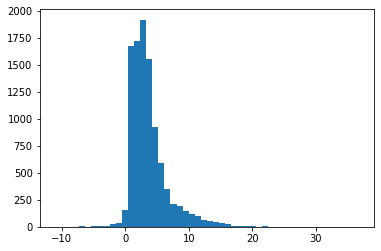

In [20]:
plt.hist(scores1['IG'][:,0] - scores1['IG'][:,1], bins=50)
plt.show()

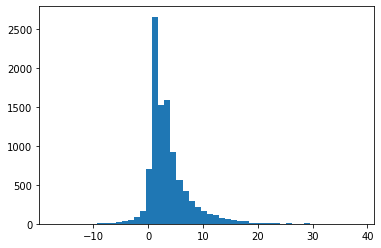

In [19]:
plt.hist(scores2['IG'][:,0] - scores2['IG'][:,1], bins=50)
plt.show()

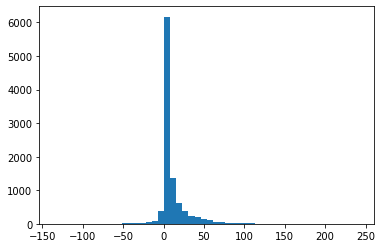

In [21]:
plt.hist(scores3['IG'][:,0] - scores3['IG'][:,1], bins=50)
plt.show()